Prompt Chaining ->

    Where we use Muliple LLM to generate final response
![](img/blog_generation.png)

In [1]:
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI
from typing import TypedDict, Optional
from dotenv import load_dotenv

In [2]:
load_dotenv()

True

In [3]:
model = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    temperature=0.2,   # good default for agents / structured tasks
)

In [4]:
class BlogState(TypedDict, total=False):
    title : str
    outline : Optional[str]
    content : Optional[str]

In [5]:
def gen_outline(state: BlogState) -> BlogState:
    # fetch the title
    title = state['title']
    
    # prompt the question for llm
    prompt = f'Generate a detailed outline on the topic - {title}'

    # generate the response
    outline = model.invoke(prompt).content

    # return the state after update
    return {
        **state,
        "outline": outline
    }

def gen_blog(state: BlogState) -> BlogState:
    title = state['title']
    outline = state['outline']

    prompt = f'Generate a detailed blog on the title - {title} using the following outline \n {outline}'

    content = model.invoke(prompt).content

    return {
        **state,
        "content": content
    }

In [6]:
# define your graph
graph = StateGraph(BlogState)

# add nodes to your graph
graph.add_node('gen_outline', gen_outline)
graph.add_node('gen_blog', gen_blog)

# add edges to your graph
graph.add_edge(START, 'gen_outline')
graph.add_edge('gen_outline', 'gen_blog')
graph.add_edge('gen_blog', END)

# compile your graph
workflow = graph.compile()

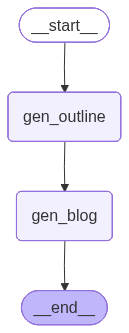

In [7]:
from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png())

In [8]:
initial_state = {'title':'Rise of AI in India'}

final_state = workflow.invoke(initial_state)

print(final_state)

{'title': 'Rise of AI in India', 'outline': '## Detailed Outline: The Rise of AI in India\n\n**Topic:** The Rise of Artificial Intelligence in India: Drivers, Applications, Challenges, and Future Outlook\n\n---\n\n**I. Introduction: India at the Forefront of the AI Revolution**\n    A. Global Context of AI Growth\n        1. Rapid advancements in machine learning, deep learning, and natural language processing.\n        2. Transformative potential across industries and societies worldwide.\n    B. India\'s Unique Position and Potential\n        1. Large, tech-savvy population and a vast digital footprint.\n        2. Strong IT services legacy and a growing startup ecosystem.\n        3. Government\'s strategic focus on digital transformation and AI adoption.\n    C. Thesis Statement: India is experiencing a significant surge in AI adoption and innovation, driven by a confluence of demographic, economic, and policy factors, positioning it as a key player in the global AI landscape despi

In [10]:
final_state['content']

'## The Rise of AI in India: Charting a Course for a Digital Future\n\nThe world is in the throes of an Artificial Intelligence revolution, a technological wave reshaping industries, economies, and societies at an unprecedented pace. From sophisticated machine learning algorithms powering personalized recommendations to deep learning models driving autonomous systems and natural language processing enabling seamless human-computer interaction, AI\'s transformative potential is undeniable. Amidst this global paradigm shift, India is not merely a spectator but is rapidly emerging as a pivotal player, charting its unique course in the AI landscape.\n\nWith its colossal, tech-savvy population, a burgeoning digital footprint, a robust legacy in IT services, and a dynamic startup ecosystem, India possesses a unique confluence of factors. Coupled with the government\'s strategic vision for digital transformation, the nation is experiencing a significant surge in AI adoption and innovation. Th

Did you observe how it was different from Langchain 

The same thing performing with Langchain by making chains -> we wouldn't have been able to get the outline of the blog 
    we would have just recieved the blog.

Here we recieve the whole as a dictionary -> Due to the concept of STATE in Langgraph....
